# Train the Model

In [ ]:
# pip install diffusers transformers accelerate datasets torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Need a custom key for this if others reference this
!kaggle datasets download -d ravidussilva/real-ai-art --unzip -p ./real_ai_art

Dataset URL: https://www.kaggle.com/datasets/ravidussilva/real-ai-art
License(s): other
100% 9.93G/9.95G [01:24<00:00, 145MB/s]
100% 9.95G/9.95G [01:24<00:00, 126MB/s]


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from glob import glob
import os

In [ ]:
img_paths = []
labels = []
data_types = []

dataset_paths = ['/content/real_ai_art/Real_AI_SD_LD_Dataset/test', '/content/real_ai_art/Real_AI_SD_LD_Dataset/train']

for p in dataset_paths:
    data_type = os.path.basename(os.path.normpath(p))
    for dir in os.listdir(p):
        path = os.path.join(p, dir)

        if os.path.isdir(path):
            # extract label
            if dir[:2] == 'AI':
                label = "ai"
            else:
                label = "real"

            image_files = glob(os.path.join(path, '*.jpg'))

            for image in image_files:
                try:
                    img = Image.open(image)
                    img.verify()

                    img_paths.append(image)
                    labels.append(label)
                    data_types.append(data_type)
                except (IOError, SyntaxError) as e:
                    print(f"Error opening image {image}: {e}")

In [ ]:
data = pd.DataFrame({
    'image_path': img_paths,
    'label': labels,
    'type': data_types
})

data.head()

image_path label  type
0  /content/real_ai_art/Real_AI_SD_LD_Dataset/tes...    ai  test
1  /content/real_ai_art/Real_AI_SD_LD_Dataset/tes...    ai  test
2  /content/real_ai_art/Real_AI_SD_LD_Dataset/tes...    ai  test
3  /content/real_ai_art/Real_AI_SD_LD_Dataset/tes...    ai  test
4  /content/real_ai_art/Real_AI_SD_LD_Dataset/tes...    ai  test

In [ ]:
data.to_csv('dataset.csv', index=False)

In [ ]:

# load csv
df = pd.read_csv('dataset.csv')
test_df = df[df['type'] == 'test']
train_df = df[df['type'] == 'train']


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image


class ArtDataset(Dataset):
    def __init__(self, df, train=True, image_size=256):
        # Filter based on train or test
        self.df = df[df['type'] == ('train' if train else 'test')]

        # Define transformations
        # Typically for diffusion models, we might map images to [-1, 1] range
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] for grayscale or extend for RGB
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        label = 1 if row['label'] == 'ai' else 0
        return image, label

train_dataset = ArtDataset(df, train=True, image_size=256)
test_dataset = ArtDataset(df, train=False, image_size=256)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



# ResNet50 Model for training (Binary Classification)

In [ ]:
### --- Load ResNet50 Model for training

import torch
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

num_features = model.fc.in_features

# Default is 1000 features we are implementing a binary classifier - real vs ai
model.fc = nn.Linear(num_features, 2)

# Freeze all layers (for speed)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze parameters in the final layer (which we just replaced)
for param in model.fc.parameters():
    param.requires_grad = True

# Optional: unfreeze last block if you want slightly more fine-tuning:
# for param in model.layer4.parameters():
#     param.requires_grad = True


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [ ]:
# Train!!!

criterion = nn.CrossEntropyLoss()

# Only parameters of the final layers are being optimized
params_to_update = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, lr=1e-3)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5  # Start with a small number, can adjust based on performance

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(test_dataset)
    val_acc = val_corrects.double() / len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")


Epoch [1/5] Train Loss: 0.1708 Acc: 0.9342 Val Loss: 0.1607 Val Acc: 0.9525
Epoch [2/5] Train Loss: 0.1488 Acc: 0.9431 Val Loss: 0.1053 Val Acc: 0.9694
Epoch [3/5] Train Loss: 0.1486 Acc: 0.9435 Val Loss: 0.1540 Val Acc: 0.9647
Epoch [4/5] Train Loss: 0.1479 Acc: 0.9438 Val Loss: 0.0832 Val Acc: 0.9719
Epoch [5/5] Train Loss: 0.1483 Acc: 0.9435 Val Loss: 0.2067 Val Acc: 0.9605


# Evaluate

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)     # Ensure images are on the same device as model
        labels = labels.to(device)

        # Get model outputs
        outputs = model(images)
        # Get predicted class with the highest score
        _, preds = torch.max(outputs, 1)

        # Move predictions and labels back to CPU and to numpy arrays for evaluation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["real", "ai"]))

# Generate confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)


Classification Report:
              precision    recall  f1-score   support

        real       0.92      0.96      0.94     10000
          ai       0.98      0.96      0.97     20000

    accuracy                           0.96     30000
   macro avg       0.95      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000

Confusion Matrix:
[[ 9633   367]
 [  819 19181]]


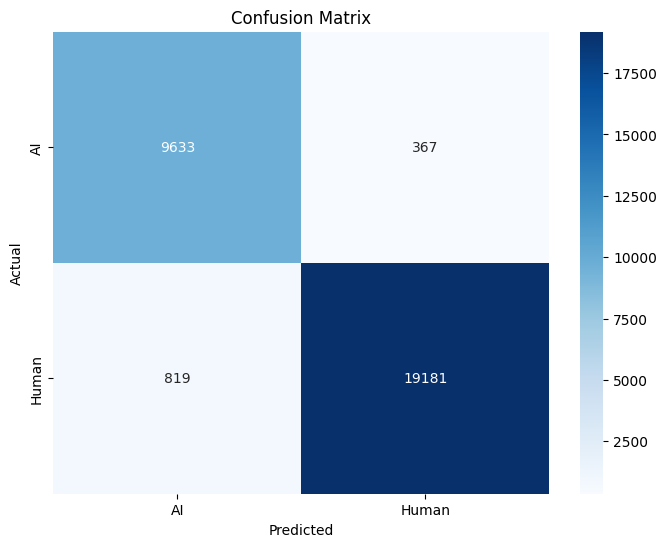

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(model.state_dict(), "model_weights-2.pth")

# Grad-Cam Evaluation

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=None)  # No pretrained weights, we'll load ours
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: real(0), ai(1)

model.load_state_dict(torch.load("model_weights.pth", map_location=device))
model.to(device)
model.summary()
model.eval()


<ipython-input-12-75c599c4b07e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth", map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class ArtDataset(Dataset):
    def __init__(self, df, train=True, image_size=256):
        split_type = 'train' if train else 'test'
        self.df = df[df['type'] == split_type].reset_index(drop=True)

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],
                                 [0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        label = 1 if row['label'] == 'ai' else 0
        return image, label, image_path

df = pd.read_csv("dataset.csv")

test_dataset = ArtDataset(df, train=False, image_size=256)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

# Assume `df` is loaded and your model is loaded as `model`.

# Separate test dataframe
test_df = df[df['type'] == 'test'].reset_index(drop=True)

# Split into AI and real subsets
ai_df = test_df[test_df['label'] == 'ai']
real_df = test_df[test_df['label'] == 'real']

# Randomly pick 5 AI and 5 real images
ai_samples = ai_df.sample(5, random_state=42)
real_samples = real_df.sample(5, random_state=42)

selected_df = pd.concat([ai_samples, real_samples]).reset_index(drop=True)

# Define a transform consistent with training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)  # shape (1, C, H, W)

# Hooks for Grad-CAM
activations = []
gradients = []

# Replace with the appropriate layer from your model
target_layer = model.layer4[-1].conv3

def forward_hook(module, inp, out):
    activations.append(out)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

handle_forward = target_layer.register_forward_hook(forward_hook)
handle_backward = target_layer.register_backward_hook(backward_hook)

def generate_gradcam(model, input_tensor, target_class=None):
    model.zero_grad()
    activations.clear()
    gradients.clear()

    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    class_score = output[0, target_class]
    class_score.backward()

    grads = gradients[-1].cpu().detach().numpy()
    acts = activations[-1].cpu().detach().numpy()[0]

    weights = np.mean(grads, axis=(1,2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam -= cam.min()
    cam /= (cam.max() + 1e-9)
    return cam

def overlay_cam_on_image(img_path, cam):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img, dtype=np.float32) / 255.0
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    overlay = 0.4 * heatmap + 0.6 * img_np
    overlay = overlay / np.max(overlay)
    overlay = (overlay * 255).astype(np.uint8)
    return overlay

# Remove hooks after done
handle_forward.remove()
handle_backward.remove()


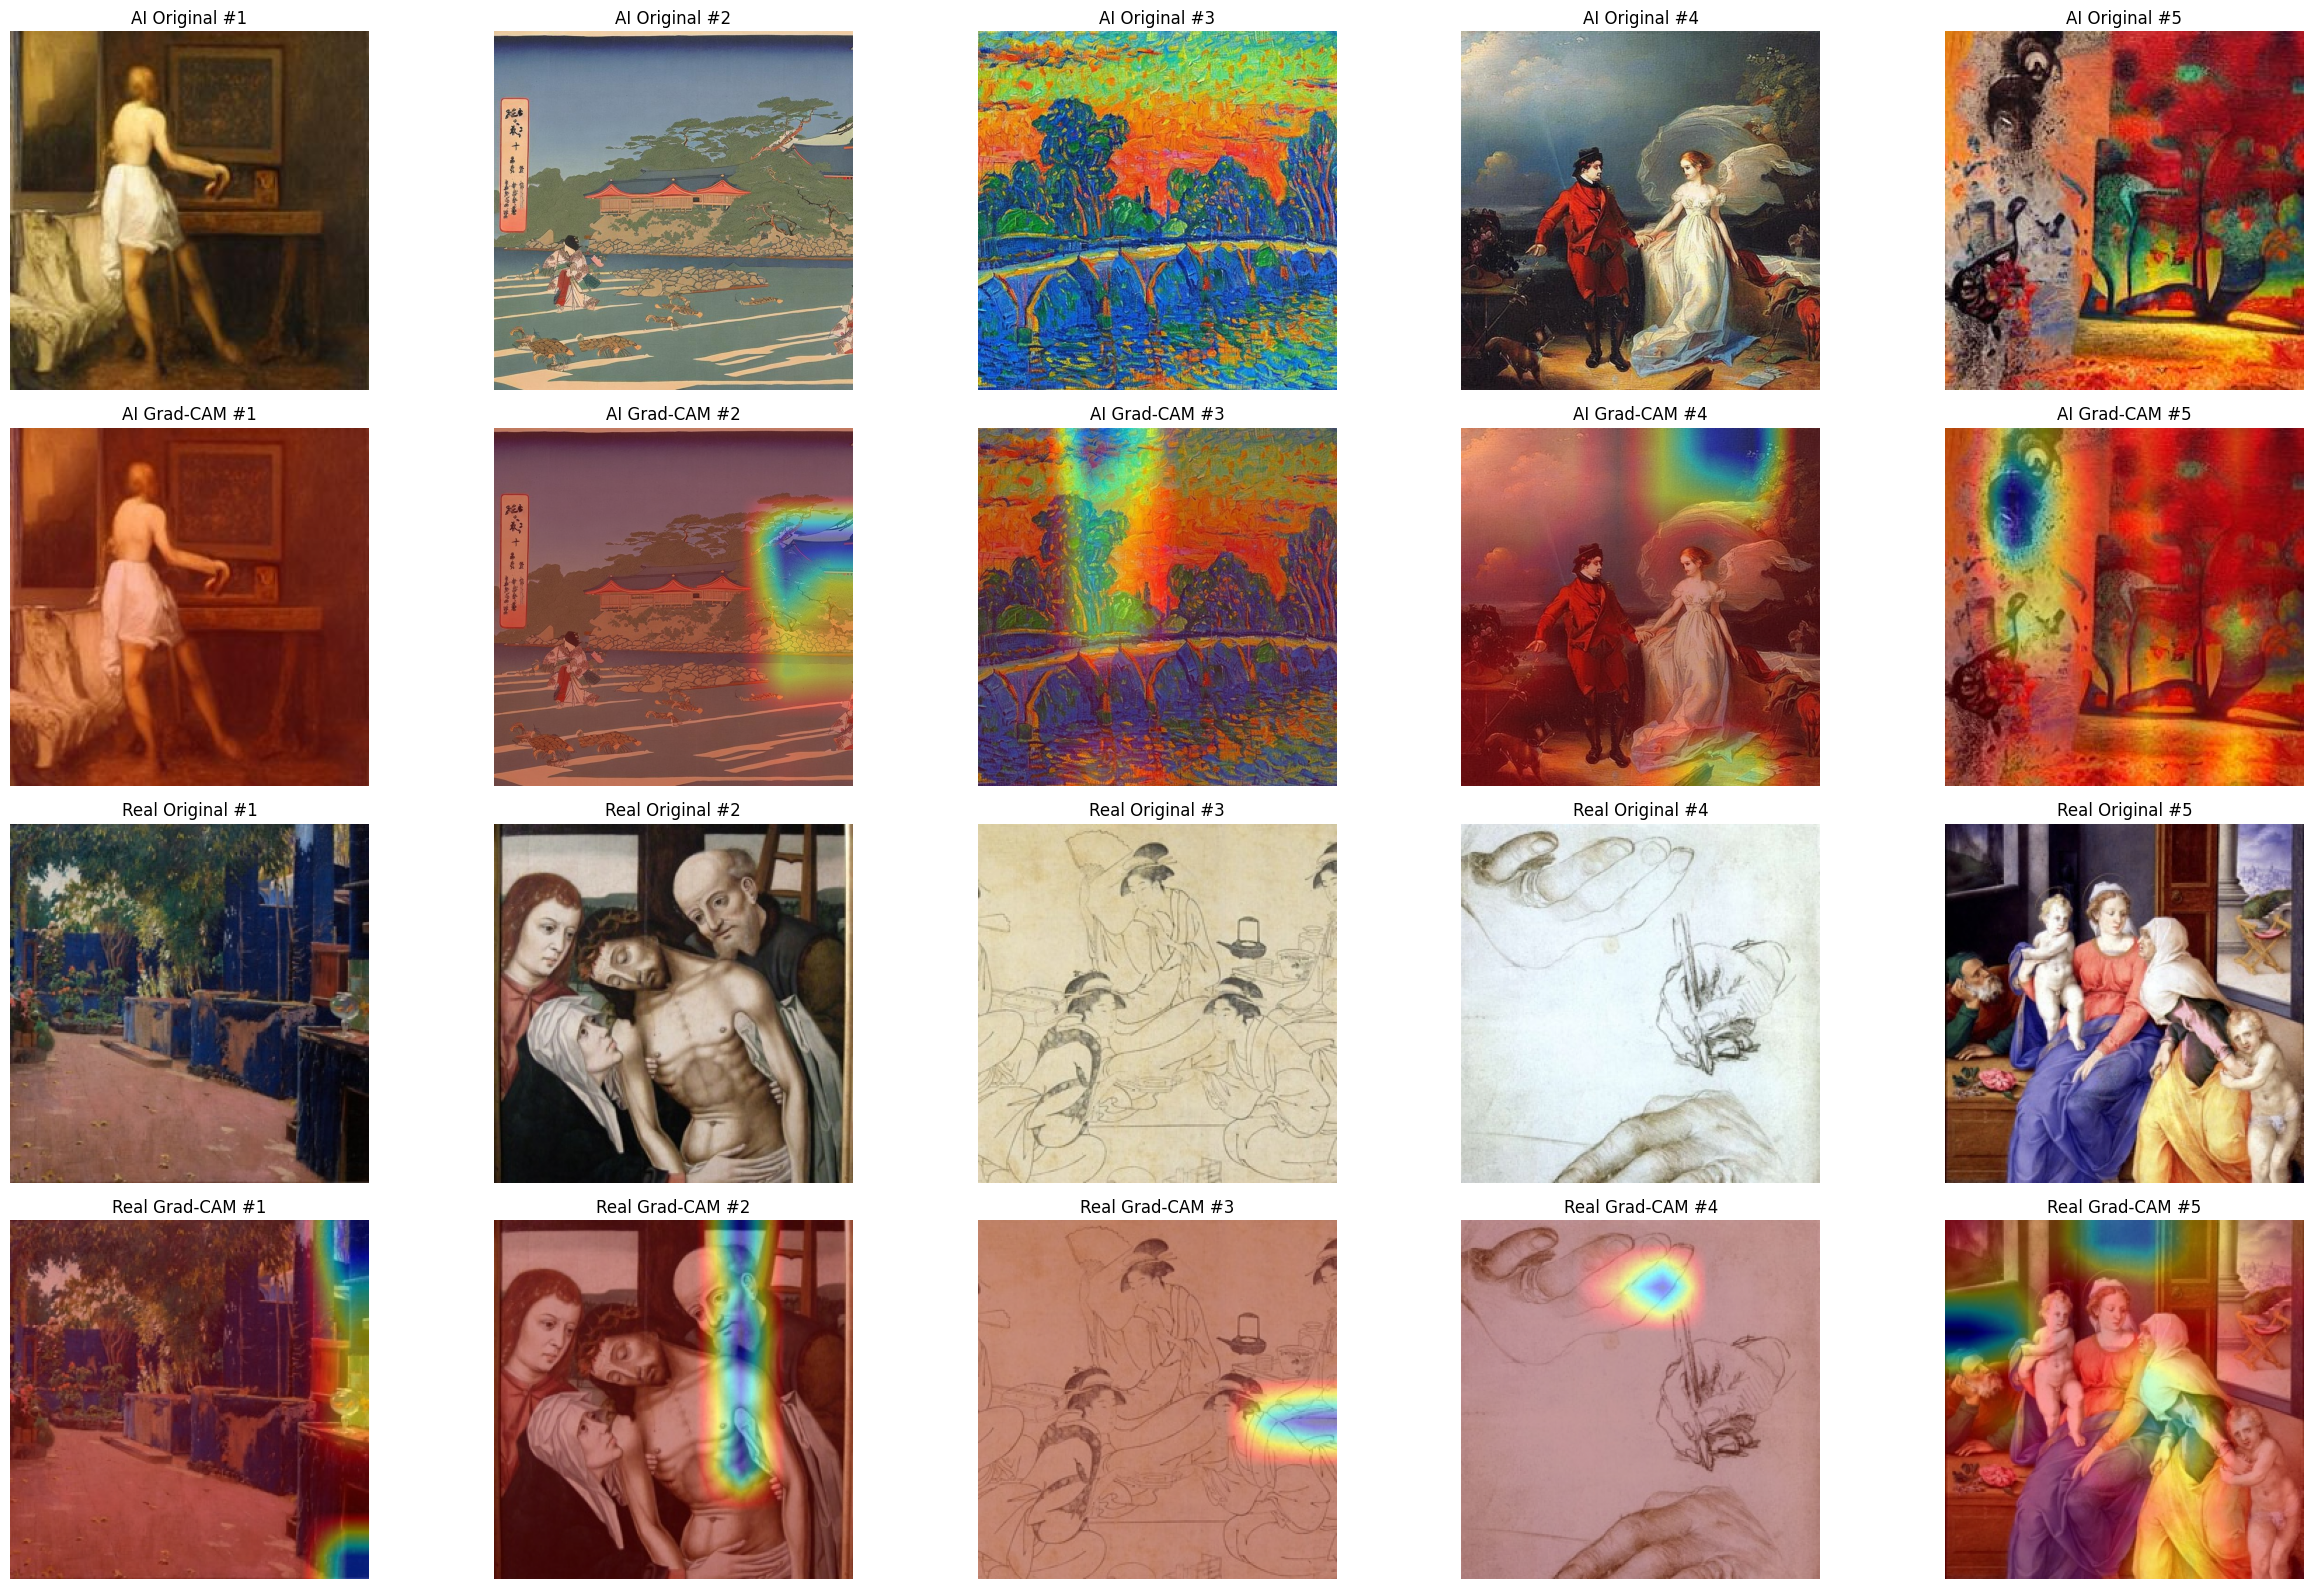

In [ ]:
# Convert the dataframes to lists of rows for easier iteration
ai_samples = ai_samples.reset_index(drop=True)
real_samples = real_samples.reset_index(drop=True)

fig, axes = plt.subplots(4, 5, figsize=(25, 16))

# Display AI images (row 0: originals, row 1: Grad-CAM)
for i, (_, row) in enumerate(ai_samples.iterrows()):
    image_path = row['image_path']
    label = row['label']  # should be 'ai'
    input_tensor = load_image(image_path).to(device)
    cam = generate_gradcam(model, input_tensor)
    overlay = overlay_cam_on_image(image_path, cam)
    original_img = Image.open(image_path).convert("RGB")

    # Original AI image in row 0
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"AI Original #{i+1}")

    # AI Grad-CAM in row 1
    axes[1, i].imshow(overlay)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"AI Grad-CAM #{i+1}")

# Display Real images (row 2: originals, row 3: Grad-CAM)
for i, (_, row) in enumerate(real_samples.iterrows()):
    image_path = row['image_path']
    label = row['label']  # should be 'real'
    input_tensor = load_image(image_path).to(device)
    cam = generate_gradcam(model, input_tensor)
    overlay = overlay_cam_on_image(image_path, cam)
    original_img = Image.open(image_path).convert("RGB")

    # Original Real image in row 2
    axes[2, i].imshow(original_img)
    axes[2, i].axis('off')
    axes[2, i].set_title(f"Real Original #{i+1}")

    # Real Grad-CAM in row 3
    axes[3, i].imshow(overlay)
    axes[3, i].axis('off')
    axes[3, i].set_title(f"Real Grad-CAM #{i+1}")

plt.tight_layout()


# ResNet50 Model for training (Style Classification)

In [ ]:
# New preprocessing
# preprocessing
img_paths = []
labels = []
styles = []
data_types = []

dataset_paths = ['real_ai_art/Real_AI_SD_LD_Dataset/test', 'real_ai_art/Real_AI_SD_LD_Dataset/train']

for p in dataset_paths:
    data_type = os.path.basename(os.path.normpath(p))
    for dir in os.listdir(p):
        path = os.path.join(p, dir)

        if os.path.isdir(path):
            # extract label and style
            if dir[:2] == 'AI':
                label = "ai"
                style = dir[6:].replace('-', '_')
            else:
                label = "real"
                style = dir.replace('-', '_')

            image_files = glob(os.path.join(path, '*.jpg'))

            for image in image_files:
                try:
                    img = Image.open(image)
                    img.verify()

                    img_paths.append(image)
                    labels.append(label)
                    styles.append(style)
                    data_types.append(data_type)
                except (IOError, SyntaxError) as e:
                    print(f"Error opening image {image}: {e}")

data = pd.DataFrame({
    'image_path': img_paths,
    'label': labels,
    'style': styles,
    'type': data_types
})

data.head()

image_path label          style  \
0  real_ai_art/Real_AI_SD_LD_Dataset/test/AI_LD_e...    ai  expressionism   
1  real_ai_art/Real_AI_SD_LD_Dataset/test/AI_LD_e...    ai  expressionism   
2  real_ai_art/Real_AI_SD_LD_Dataset/test/AI_LD_e...    ai  expressionism   
3  real_ai_art/Real_AI_SD_LD_Dataset/test/AI_LD_e...    ai  expressionism   
4  real_ai_art/Real_AI_SD_LD_Dataset/test/AI_LD_e...    ai  expressionism   

   type  
0  test  
1  test  
2  test  
3  test  
4  test

In [ ]:
data['style'].unique()

data.to_csv('style_dataset.csv', index=False)

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os

In [ ]:
# load csv
df = pd.read_csv('style_dataset.csv')
test_df = df[df['type'] == 'test']
train_df = df[df['type'] == 'train']

In [ ]:
class ArtDataset(Dataset):
    def __init__(self, df, feature_extractor, train=True):
        self.df = df[df['type'] == ('train' if train else 'test')]
        self.feature_extractor = feature_extractor
        self.label_mapping = {label: idx for idx, label in enumerate(df['style'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze()

        label = self.label_mapping[row['style']]
        return pixel_values, label